In [1]:
# EDA and Survival Prediction using NumPy, Pandas, Matplotlib, Seaborn and Sklearn
# Various visualizations were used to illustrate who and why people were survived or didn't survive
# Random Forest was carefully selected out with the help of cross validation and confusion matrix
# After fine tuning, the Random Forest model reached an accuracy of 87.3%

In [2]:
import pandas as pd
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
train_df = pd.read_csv('train.csv')
print(f'Train dataset has {train_df.shape[0]} rows and {train_df.shape[1]} columns.')

Train dataset has 891 rows and 12 columns.


In [4]:
# Dataset overview
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Begin to clean the Train data
# Check data types
train_df.dtypes
# All good

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
# Check missing values
train_df.isnull().sum()
# There are missing values in columns of "Age", "Cabin" and "Embarked".

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# Deal with missing values
# Cabin: Drop this variable because the majority of its values are missing
train_df = train_df.drop(['Cabin'], axis=1)

In [8]:
# Age: Didn't fill null values with mean age 
# due to a large number of missing values in this variable: almost one fourth!
# Try to replace null values more accurately
# Check the Name
train_df['Title'] = 0
for i in train_df:
    train_df['Title'] = train_df.Name.str.extract('([A-Za-z]+)\.')

In [9]:
# Group "Title" and find mean age in each group
# Age can be reflected by passengers' titles.
train_df.groupby('Title')['Age'].mean()
# Too many categories

Title
Capt        70.000000
Col         58.000000
Countess    33.000000
Don         40.000000
Dr          42.000000
Jonkheer    38.000000
Lady        48.000000
Major       48.500000
Master       4.574167
Miss        21.773973
Mlle        24.000000
Mme         24.000000
Mr          32.368090
Mrs         35.898148
Ms          28.000000
Rev         43.166667
Sir         49.000000
Name: Age, dtype: float64

In [10]:
# Check gender and frequency under "Title"
pd.crosstab(train_df.Title, train_df.Sex).T.style.background_gradient(cmap='summer_r')

Title,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [11]:
# Most frequent titles are "Miss", "Mr", "Mrs" and "Master", so it would be easier if the rest of the titles can be merged into categories of four titles.
# A man was titled "Capt", so "Capt" goes to "Mr".
# Similarly, "Col", "Don", "Jonkheer", "Major", "Rev" and "Sir" go to "Mr".
# "Countess" refers to a female, and the mean age of "Countess" is similar to that of "Mrs", so "Countess" goes to "Mrs".
# The mean age for "Lady" is 48, so to me it is more suitable to put it into "Mrs".
# "Mlle" is "Miss" in French; "Mme" is "Madame" in French
# In this data, the mean ages of "Ms", Miss", "Mlle" and "Mme" are similar, so they'll be merged into category "Miss"
# "Dr" is complicated so I just keep it as it was.
train_df['Title'].replace(['Capt','Col','Countess','Don','Jonkheer','Lady','Major','Mlle','Mme', 'Ms',  'Rev','Sir'],
                          ['Mr',   'Mr','Mrs',     'Mr', 'Mr',      'Mrs', 'Mr',   'Miss','Miss','Miss','Mr','Mr'],
                        inplace=True)

In [12]:
train_df.groupby('Title')['Age'].mean()

Title
Dr        42.000000
Master     4.574167
Miss      21.860000
Mr        32.891990
Mrs       35.981818
Name: Age, dtype: float64

In [13]:
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Dr'),'Age']=42
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Master'),'Age']=4.6
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Title=='Mrs'),'Age']=36

In [14]:
# Embarked: Replace missing values with mode
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [15]:
train_df.isnull().sum()
# Now there is no missing value
# Start EDA

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64

Text(0.5, 1.0, 'How many people survived from the disaster?')

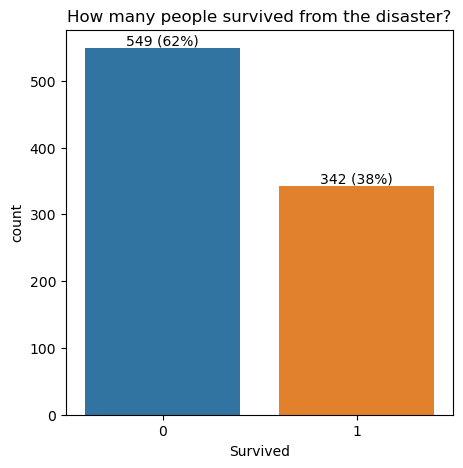

In [16]:
# How many people survived from the disaster?
plt.figure(figsize=(5, 5))
ax = sns.countplot(x=train_df['Survived'])      
abs_values = train_df['Survived'].value_counts(ascending=False)
rel_values = train_df['Survived'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
ax.bar_label(container=ax.containers[0], labels=lbls)
plt.title('How many people survived from the disaster?')
# Out of the 891 passengers in the training dataset, 342 (38%) were rescued from the Titanic.

In [17]:
# Who survived and who did not?
# Look into it by each variable
# 1. Pclass
print('''
1. From "Pclass", we can see that 136 people survived from the first class, 
   while only 119 people survived from the third class.
2. The number of passengers in the first class is 216 and that in the third class is 491.
3. More passengers were in the third class (491) than passengers in the first and second class added together (400), 
   but the number of survivors were less than that in the other two classes (119 vs 223).
''')
pd.crosstab(train_df.Pclass, train_df.Survived, margins=True).style.background_gradient(cmap='summer_r')


1. From "Pclass", we can see that 136 people survived from the first class, 
   while only 119 people survived from the third class.
2. The number of passengers in the first class is 216 and that in the third class is 491.
3. More passengers were in the third class (491) than passengers in the first and second class added together (400), 
   but the number of survivors were less than that in the other two classes (119 vs 223).



Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [18]:
print('''
4. Over half of the people were in the third class, but most of them were dead. 
''')
crosstab = pd.crosstab(train_df.Pclass, train_df.Survived, normalize=True, margins=True, margins_name="Total")
crosstab.style.format("{:.0%}").background_gradient(cmap='summer_r')


4. Over half of the people were in the third class, but most of them were dead. 



Survived,0,1,Total
Pclass,,,
1,9%,15%,24%
2,11%,10%,21%
3,42%,13%,55%
Total,62%,38%,100%



5. People in the first class had the highest survival rate(0.63), 
   compared to the second class(0.47) and the third class(0.24).



Text(0.5, 1.0, 'Survival Rate by Pclass')

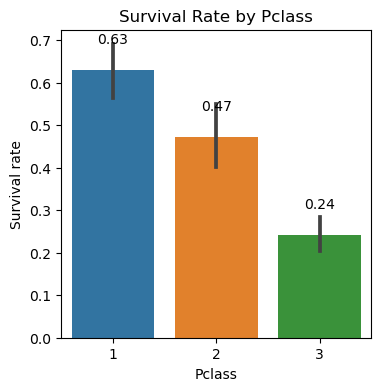

In [19]:
print('''
5. People in the first class had the highest survival rate(0.63), 
   compared to the second class(0.47) and the third class(0.24).
''')
plt.figure(figsize=(4, 4))
aw = sns.barplot(x='Pclass', y='Survived', data=train_df)
aw.bar_label(aw.containers[0], fmt='%.2f', padding=17)
aw.set_ylabel('Survival rate')
plt.title('Survival Rate by Pclass')


1. The number of women rescued was nearly 2 times as much as that of men who got rescued.
2. The percentage of men being rescued was far less than that of women(over 70%).



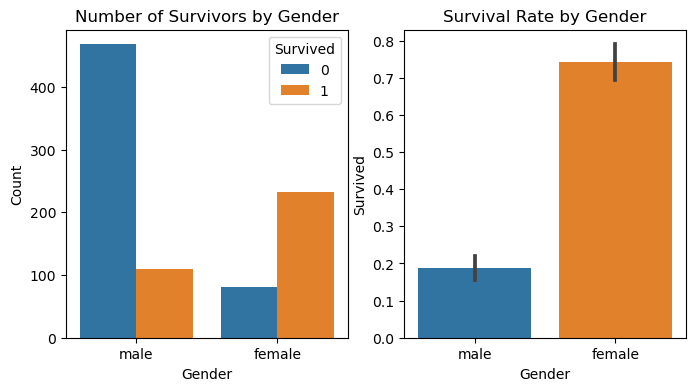

In [20]:
# 2. Sex
print('''
1. The number of women rescued was nearly 2 times as much as that of men who got rescued.
2. The percentage of men being rescued was far less than that of women(over 70%).
''')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='Sex', hue='Survived', data=train_df)
plt.title('Number of Survivors by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.show()

In [21]:
# 3. Age
# Find the youngest and the oldest person
print('The oldest passenger was', train_df['Age'].max(), 'years old.')
print('The youngest passenger was', train_df['Age'].min(), 'years old.')
print('The average age of all passengers was about', round(train_df['Age'].mean()), 'years old.')

The oldest passenger was 80.0 years old.
The youngest passenger was 0.42 years old.
The average age of all passengers was about 30 years old.



1. The mean ages of all passengers, people who survived and people who didn't survive were all around 30.
2. All passengers aged 65-75 were dead during the disaster, but the oldest person(80 years old) was rescued.
3. The youngest kid in the third class got rescued.



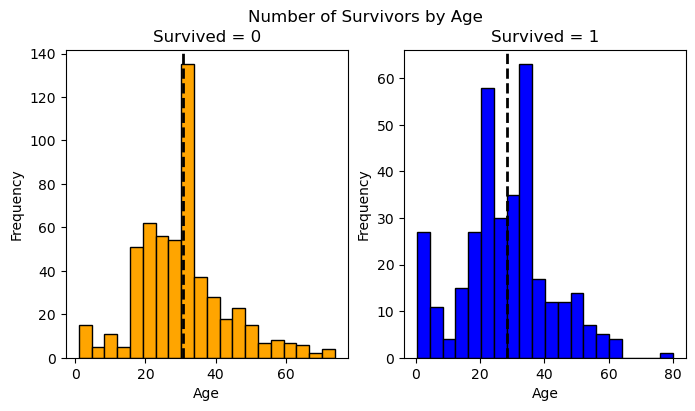

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.00,0,0,27042,30.0000,S,Mr
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,C,Master


In [22]:
# A histogram is used 
print('''
1. The mean ages of all passengers, people who survived and people who didn't survive were all around 30.
2. All passengers aged 65-75 were dead during the disaster, but the oldest person(80 years old) was rescued.
3. The youngest kid in the third class got rescued.
''')
g,ax = plt.subplots(1, 2, figsize=(8, 4))
train_df[train_df['Survived']==0].Age.plot.hist(ax=ax[0], bins=20, edgecolor='black', color='orange')
ax[0].set_xlabel('Age')
ax[0].set_title('Survived = 0')
train_df[train_df['Survived']==1].Age.plot.hist(ax=ax[1], color='blue', bins=20, edgecolor='black')
ax[1].set_xlabel('Age')
ax[1].set_title('Survived = 1')
ax[0].axvline(mean(train_df[train_df['Survived']==0].Age), color='black', linestyle='dashed', linewidth=2)
ax[1].axvline(mean(train_df[train_df['Survived']==1].Age), color='black', linestyle='dashed', linewidth=2)
g.suptitle('Number of Survivors by Age')
plt.show()
train_df.loc[(train_df.Age==80)|(train_df.Age==0.42)]

In [23]:
# Want to refer numbers of ages to certain names
age_group = [] 
for i in train_df['Age']: 
    if i <= 12: 
        age_group.append('Children') 
    elif i <= 30: 
        age_group.append('Youth') 
    elif i <= 50: 
        age_group.append('Middle-aged') 
    else: 
        age_group.append('Senior') 
train_df['Age_group'] = age_group


1. In each age group, more people were dead than rescued except for "Children". 
2. The survival rate of children was the largest, while middle-aged and senior passengers had the lowest survial 
   rate.



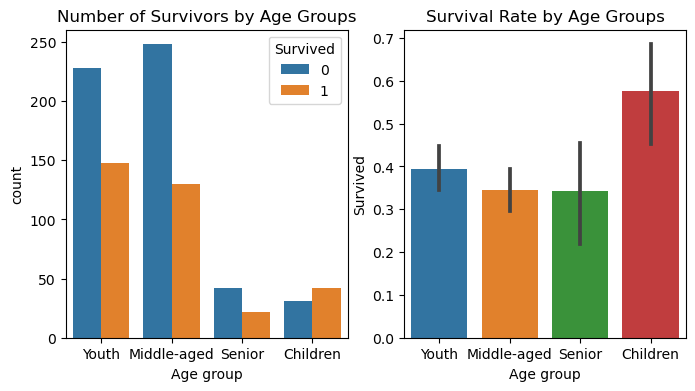

In [24]:
# Find out survivor distribution in each age group
print('''
1. In each age group, more people were dead than rescued except for "Children". 
2. The survival rate of children was the largest, while middle-aged and senior passengers had the lowest survial 
   rate.
''')
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='Age_group', hue='Survived', data=train_df)
plt.xlabel('Age group')
plt.title('Number of Survivors by Age Groups')
plt.subplot(1, 2, 2)
sns.barplot(x='Age_group', y='Survived', data=train_df)
plt.title('Survival Rate by Age Groups')
plt.xlabel('Age group')
plt.show()


1. Passengers with 1 sibling/spouse had the highest chance of survival.
2. The chances of survival for those who boarded alone or with two sibling/spouse were also good.
3. No one survived with a family size of 6 and 9. (No records of family size 7 and 8)
4. The survival rate declined significantly when having 3 sibling/spouse.



Text(0.5, 1.0, 'Number of Survivors by Sibling/Spouse')

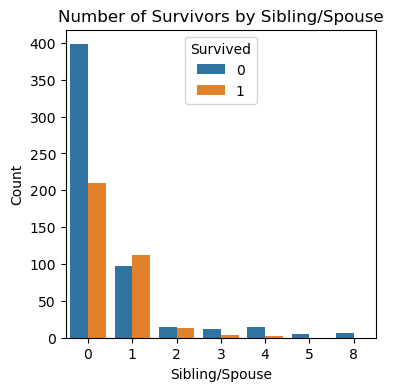

In [25]:
# 4. SibSp
# Did the number of sibling/spouse affect the survival rate?
print('''
1. Passengers with 1 sibling/spouse had the highest chance of survival.
2. The chances of survival for those who boarded alone or with two sibling/spouse were also good.
3. No one survived with a family size of 6 and 9. (No records of family size 7 and 8)
4. The survival rate declined significantly when having 3 sibling/spouse.
''')
plt.figure(figsize=(4, 4))
sns.countplot(x='SibSp', hue='Survived', data=train_df)
plt.xlabel('Sibling/Spouse')
plt.ylabel('Count')
plt.title('Number of Survivors by Sibling/Spouse') 


1. The survival rate is high when people were together with 1-3 parent/child.



Text(0.5, 1.0, 'Number of Survivors by Parent/Child')

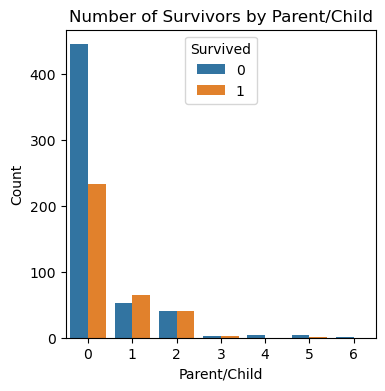

In [26]:
# 5. Parch
# Did the number of parent/child on board affect the survival rate?
print('''
1. The survival rate is high when people were together with 1-3 parent/child.
''')
plt.figure(figsize=(4, 4))
sns.countplot(x='Parch', hue='Survived', data=train_df)
plt.xlabel('Parent/Child')
plt.ylabel('Count')
plt.title('Number of Survivors by Parent/Child') 

In [27]:
# 6. Ticket
# Currently, the information in "Ticket" seems irrelevant to the question "Who survived and who did not?".
# So this variable was not explored temporarily.

In [28]:
# 7. Fare
# Look at the features inside "Fare"
print('The highest price is', train_df['Fare'].max())
print('The lowest price is', train_df['Fare'].min())
print('The average price is', train_df['Fare'].mean())
print('How many passengers got free tickets?', len(train_df[(train_df.Fare==0)]))
print('''
1. 15 passengers got free tickets for all types of classes on Titanic.
2. Five passengers got the first class tickets for free.
3. All of them didn't survive except for a 25-year-old man from the third class. What a lucky guy!
''')
train_df.loc[(train_df.Fare==train_df['Fare'].min())]

The highest price is 512.3292
The lowest price is 0.0
The average price is 32.2042079685746
How many passengers got free tickets? 15

1. 15 passengers got free tickets for all types of classes on Titanic.
2. Five passengers got the first class tickets for free.
3. All of them didn't survive except for a 25-year-old man from the third class. What a lucky guy!



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_group
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,Mr,Middle-aged
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,S,Mr,Middle-aged
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,Mr,Youth
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,33.0,0,0,239853,0.0,S,Mr,Middle-aged
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,Mr,Youth
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,33.0,0,0,239853,0.0,S,Mr,Middle-aged
466,467,0,2,"Campbell, Mr. William",male,33.0,0,0,239853,0.0,S,Mr,Middle-aged
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,33.0,0,0,239854,0.0,S,Mr,Middle-aged
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,Mr,Middle-aged
633,634,0,1,"Parr, Mr. William Henry Marsh",male,33.0,0,0,112052,0.0,S,Mr,Middle-aged



1. The survivors had expensive tickets.
2. All passengers holding the most expensive tickets got rescued.
3. The survival rate increased as the ticket price went up.



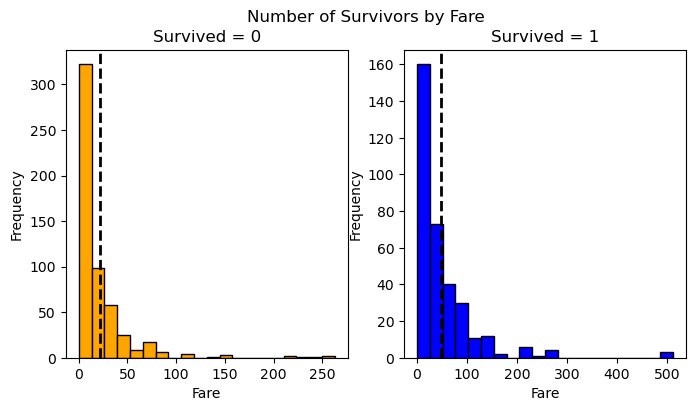

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_group
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,Miss,Middle-aged
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,Mr,Middle-aged
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,Mr,Middle-aged


In [29]:
# Is there any relationship between the price of the ticket and the chances of survival?
print('''
1. The survivors had expensive tickets.
2. All passengers holding the most expensive tickets got rescued.
3. The survival rate increased as the ticket price went up.
''')
f,at = plt.subplots(1, 2, figsize=(8, 4))
train_df[train_df['Survived']==0].Fare.plot.hist(ax=at[0], bins=20, edgecolor='black', color='orange')
at[0].set_xlabel('Fare')
at[0].set_title('Survived = 0')
train_df[train_df['Survived']==1].Fare.plot.hist(ax=at[1], color='blue', bins=20, edgecolor='black')
at[1].set_xlabel('Fare')
at[1].set_title('Survived = 1')
at[0].axvline(mean(train_df[train_df['Survived']==0].Fare), color='black', linestyle='dashed', linewidth=2)
at[1].axvline(mean(train_df[train_df['Survived']==1].Fare), color='black', linestyle='dashed', linewidth=2)
f.suptitle('Number of Survivors by Fare')
plt.show()
train_df.loc[(train_df.Fare==train_df['Fare'].max())]

In [30]:
train_df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [31]:
fare_range = [] 
for i in train_df['Fare']: 
    if i <= 7.910400: 
        fare_range.append('Low-25%') 
    elif i <= 14.454200: 
        fare_range.append('Low-50%') 
    elif i <= 31.000000: 
        fare_range.append('High-75%') 
    elif i <= 512.329200: 
        fare_range.append('High-100%') 
train_df['Fare_range'] = fare_range

In [32]:
train_df.groupby(['Fare_range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_range,
High-100%,0.581081
High-75%,0.454955
Low-25%,0.197309
Low-50%,0.303571



1. Over half of the passengers embarked at Cherbourg survived.
2. Passengers who embarked at Southampton survived the least.
3. Around 40% passengers who embarked at Queenstown got rescued.



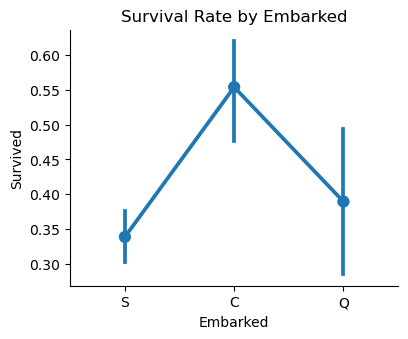

In [33]:
# 8. Embarked
print('''
1. Over half of the passengers embarked at Cherbourg survived.
2. Passengers who embarked at Southampton survived the least.
3. Around 40% passengers who embarked at Queenstown got rescued.
''')
sns.catplot(data=train_df, x='Embarked', y='Survived', kind='point')
fig=plt.gcf()
fig.set_size_inches(4,3)
plt.title('Survival Rate by Embarked') 
plt.show()

In [34]:
print('''
By far, I have explored each variable to answer the first general question:
      Who survived and who did not?
And the findings are:
 1. People in the first class had the highest survival rate(0.63), compared to the second class(0.47) and the 
    third class(0.24).
 2. Over 70% women on board got rescued.
 3. Most passengers were the young and the middle-aged, but children had the highest chance of survial, 
    and middle-aged as well as senior passengers had the lowest survial rate.
 4. Small family size (under 3) had higher chances of survival, and passengers with 1 sibling/spouse or 
    parent/child had the highest chance of survival.
 5. The more people paid for the tickets, the more likely they would survive.
 6. Over half of the passengers embarked at Cherbourg survived, while passengers who embarked at Southampton 
    survived the least.
      ''')


By far, I have explored each variable to answer the first general question:
      Who survived and who did not?
And the findings are:
 1. People in the first class had the highest survival rate(0.63), compared to the second class(0.47) and the 
    third class(0.24).
 2. Over 70% women on board got rescued.
 3. Most passengers were the young and the middle-aged, but children had the highest chance of survial, 
    and middle-aged as well as senior passengers had the lowest survial rate.
 4. Small family size (under 3) had higher chances of survival, and passengers with 1 sibling/spouse or 
    parent/child had the highest chance of survival.
 5. The more people paid for the tickets, the more likely they would survive.
 6. Over half of the passengers embarked at Cherbourg survived, while passengers who embarked at Southampton 
    survived the least.
      


In [35]:
# Why the first class?
# Why women and children?
# Why Cherbourg?


Money secured safety.

1. The first class tickets were more expensive on average.
2. People who paid for the highest price got rescued. Even though two of them were men.



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_group,Fare_range
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C,Miss,Middle-aged,High-100%
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C,Mr,Middle-aged,High-100%
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C,Mr,Middle-aged,High-100%


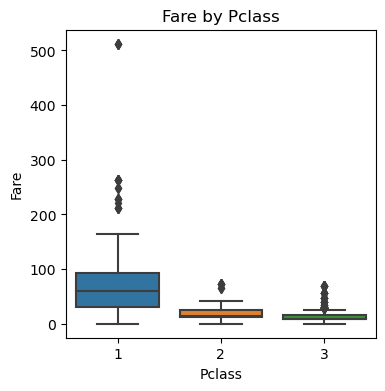

In [36]:
print('''
Money secured safety.

1. The first class tickets were more expensive on average.
2. People who paid for the highest price got rescued. Even though two of them were men.
''')
plt.figure(figsize=(4, 4))
sns.boxplot(x='Pclass', y='Fare', data=train_df)
plt.title('Fare by Pclass')
train_df.loc[(train_df.Fare==train_df['Fare'].max())]

In [37]:
print('''
Women and children were given the first priority during the rescue.

1. Mean ages for men and women were similar.
2. In each class on the Titanic, more women and children were rescued.
3. Different class type did have different impact on women and children's survival rate. For in the first and second 
   class, women's survival rate reached around 0.9, compared to about 0.5 in the third class; All children were saved 
   in the second class! 
4. The youngest kid got rescued, though the child was in the third class.
''')


Women and children were given the first priority during the rescue.

1. Mean ages for men and women were similar.
2. In each class on the Titanic, more women and children were rescued.
3. Different class type did have different impact on women and children's survival rate. For in the first and second 
   class, women's survival rate reached around 0.9, compared to about 0.5 in the third class; All children were saved 
   in the second class! 
4. The youngest kid got rescued, though the child was in the third class.



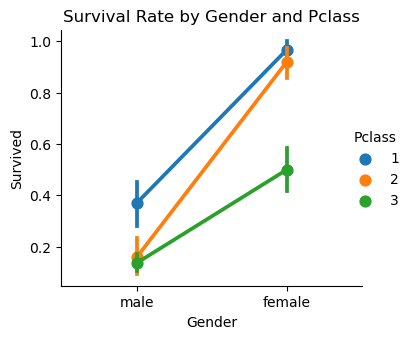

In [38]:
sns.catplot(x='Sex',y='Survived',hue='Pclass',data=train_df,kind='point')
fig=plt.gcf()
fig.set_size_inches(4,3)
plt.xlabel('Gender')
plt.title('Survival Rate by Gender and Pclass')
plt.show()

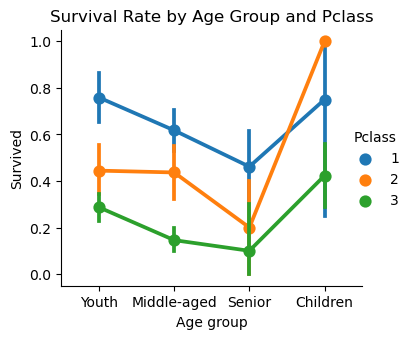

In [39]:
sns.catplot(x='Age_group',y='Survived',hue='Pclass',data=train_df,kind='point')
fig=plt.gcf()
fig.set_size_inches(4,3)
plt.xlabel('Age group')
plt.title('Survival Rate by Age Group and Pclass')
plt.show()

In [40]:
print(train_df.groupby('Sex')['Age'].mean())
train_df.loc[(train_df.Age==0.42)]

Sex
female    27.675159
male      31.033917
Name: Age, dtype: float64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_group,Fare_range
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,C,Master,Children,Low-50%


In [41]:
print('''
The highest survival rate for passengers boarded at Cherbourg was due to a fairly large proportion of 
passengers with high socio-economic status.
''')
train_df[['Fare', 'Pclass', 'Embarked']].groupby('Embarked').mean()


The highest survival rate for passengers boarded at Cherbourg was due to a fairly large proportion of 
passengers with high socio-economic status.



,Fare,Pclass
Embarked,,
C,59.954144,1.886905
Q,13.276030,2.909091
S,27.243651,2.346749


In [42]:
crosstab = pd.crosstab(train_df.Embarked, train_df.Sex, normalize=True, margins=True, margins_name="Total")
crosstab.style.format("{:.0%}").background_gradient(cmap='summer_r')

Sex,female,male,Total
Embarked,,,
C,8%,11%,19%
Q,4%,5%,9%
S,23%,49%,73%
Total,35%,65%,100%


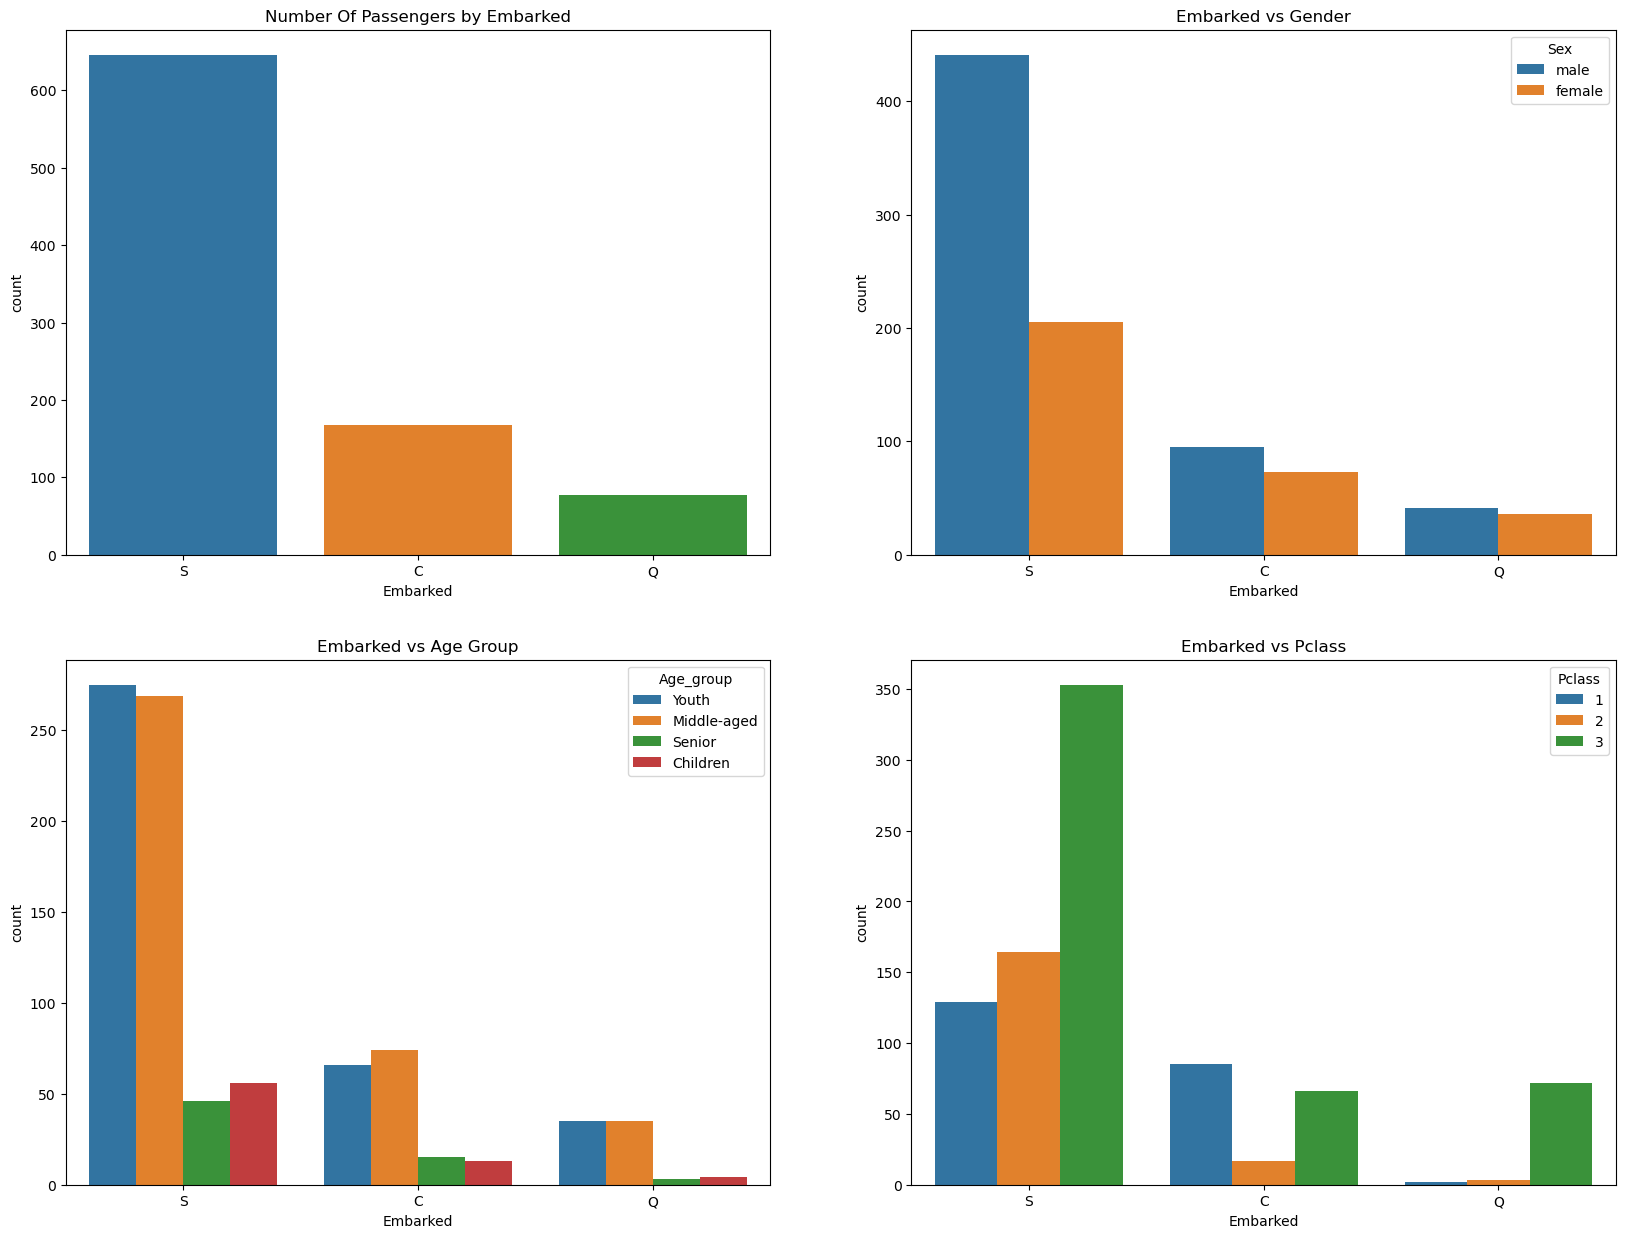

In [43]:
f,ae=plt.subplots(2,2,figsize=(20,15))
sns.countplot(x='Embarked',data=train_df,ax=ae[0,0])
ae[0,0].set_title('Number Of Passengers by Embarked')
sns.countplot(x='Embarked',hue='Sex',data=train_df,ax=ae[0,1])
ae[0,1].set_title('Embarked vs Gender')
sns.countplot(x='Embarked',hue='Age_group',data=train_df,ax=ae[1,0])
ae[1,0].set_title('Embarked vs Age Group')
sns.countplot(x='Embarked',hue='Pclass',data=train_df,ax=ae[1,1])
ae[1,1].set_title('Embarked vs Pclass')
plt.show()

In [44]:
# Time for prediction
# Step1 Explore correlation


The features are not much correlated. 
The strongest correlation is between Pclass and Fare (-0.55).



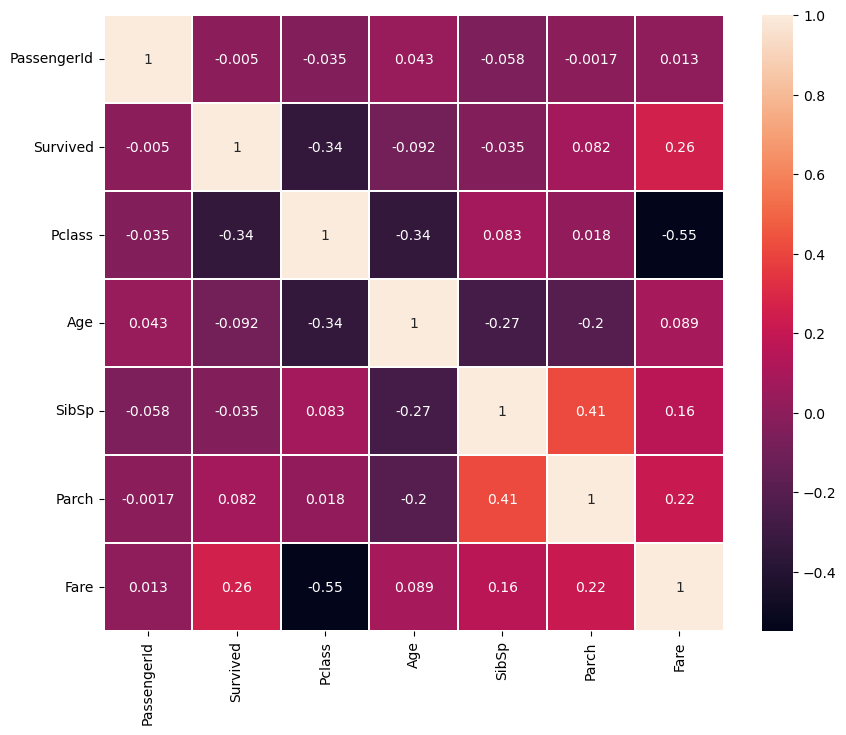

In [45]:
print('''
The features are not much correlated. 
The strongest correlation is between Pclass and Fare (-0.55).
''')
sns.heatmap(train_df.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

In [46]:
# Step2 Feature engineering
# Already added new features of "Title", "Age_group" and "Fare_range"
# Transform categorical features to numeric features into a new dataset
train_num = train_df
train_num.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title,Age_group,Fare_range
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,Youth,Low-25%
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,Middle-aged,High-100%
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,Youth,Low-50%
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,Middle-aged,High-100%
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,Middle-aged,Low-50%


In [47]:
train_num['Sex'].replace(['male','female'],[0,1],inplace=True)
train_num['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
train_num['Title'].replace(['Mr','Mrs','Miss','Master','Dr'],[0,1,2,3,4],inplace=True)
train_num['Age_group'].replace(['Children','Youth','Middle-aged','Senior'],[0,1,2,3],inplace=True)
train_num['Fare_range'].replace(['Low-25%','Low-50%','High-75%','High-100%'],[0,1,2,3],inplace=True)

In [48]:
train_df.drop(['Name','Age','Ticket','Fare','PassengerId'],axis=1,inplace=True)

In [49]:
train_num.head()

,Survived,Pclass,Sex,SibSp,Parch,Embarked,Title,Age_group,Fare_range
0,0,3,0,1,0,0,0,1,0
1,1,1,1,1,0,1,1,2,3
2,1,3,1,0,0,0,2,1,1
3,1,1,1,1,0,0,1,2,3
4,0,3,0,0,0,0,0,2,1


In [50]:
from sklearn.model_selection import train_test_split

In [51]:
# Step3 Split data into train and test
train,test = train_test_split(train_num,test_size=0.3,random_state=0,stratify=train_num['Survived'])
train_X = train[train.columns[1:]]
train_Y = train[train.columns[:1]]
test_X = test[test.columns[1:]]
test_Y = test[test.columns[:1]]
X = train_num[train_num.columns[1:]]
Y = train_num['Survived']

In [52]:
# Step4 Choose classification algorithmns
# Measure accuracy

In [53]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [54]:
model = RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y.values.ravel())
prediction1 = model.predict(test_X)
print('The accuracy of the Random Forest is',metrics.accuracy_score(prediction1,test_Y))

The accuracy of the Random Forest is 0.8134328358208955


In [55]:
model = GaussianNB()
model.fit(train_X,train_Y.values.ravel())
prediction2 = model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction2,test_Y))

The accuracy of the NaiveBayes is 0.8171641791044776


In [56]:
model = LogisticRegression()
model.fit(train_X,train_Y.values.ravel())
prediction3 = model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

The accuracy of the Logistic Regression is 0.8059701492537313


In [57]:
model = DecisionTreeClassifier()
model.fit(train_X,train_Y.values.ravel())
prediction4 = model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

The accuracy of the Decision Tree is 0.7910447761194029


In [58]:
# Step5 Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

Overall, Random Forest performed the best among the four models.


,CV Mean,Std
Logistic Regression,0.801361,0.029641
Naive Bayes,0.809164,0.047265
Random Forest,0.817016,0.047547
Decision Tree,0.810350,0.044670


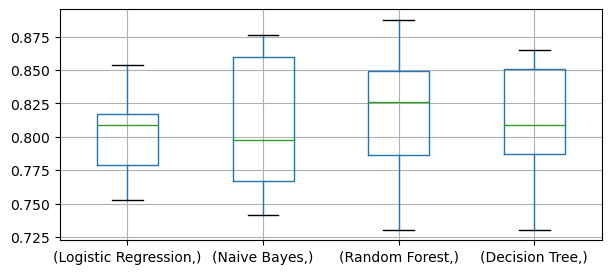

In [59]:
print("Overall, Random Forest performed the best among the four models.")
kfold = KFold(n_splits=10, shuffle=True)
xyz = []
accuracy = []
std = []
classifiers = ['Logistic Regression','Naive Bayes','Random Forest','Decision Tree']
models = [LogisticRegression(),GaussianNB(),RandomForestClassifier(n_estimators=100),DecisionTreeClassifier()]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y,cv=kfold,scoring="accuracy")
    cv_result = cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
plt.subplots(figsize=(7,3))
box = pd.DataFrame(accuracy,index=[classifiers])
box.T.boxplot()
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

In [60]:
from sklearn.metrics import confusion_matrix


Decision Tree was good at predicting the dead, 
while Naive Bayes was good at predicting the surviviors.
Random Forest performed the best overall.



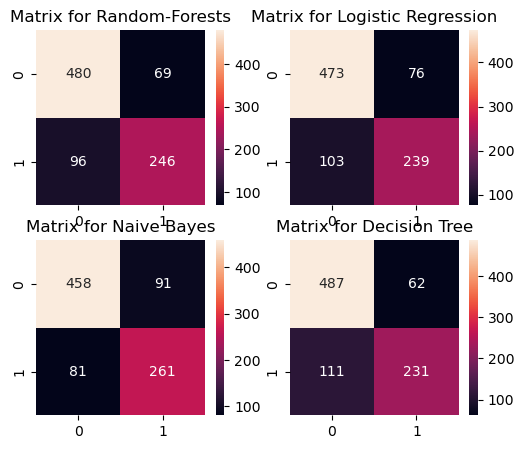

In [61]:
print('''
Decision Tree was good at predicting the dead, 
while Naive Bayes was good at predicting the surviviors.
Random Forest performed the best overall.
''')
f,ap = plt.subplots(2,2,figsize=(6,5))
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ap[0,0],annot=True,fmt='2.0f')
ap[0,0].set_title('Matrix for Random-Forests')
y_pred = cross_val_predict(LogisticRegression(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ap[0,1],annot=True,fmt='2.0f')
ap[0,1].set_title('Matrix for Logistic Regression')
y_pred = cross_val_predict(GaussianNB(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ap[1,0],annot=True,fmt='2.0f')
ap[1,0].set_title('Matrix for Naive Bayes')
y_pred = cross_val_predict(DecisionTreeClassifier(),X,Y,cv=10)
sns.heatmap(confusion_matrix(Y,y_pred),ax=ap[1,1],annot=True,fmt='2.0f')
ap[1,1].set_title('Matrix for Decision Tree')
plt.show()

In [62]:
# Step6 Tune the model
from sklearn.model_selection import GridSearchCV
n_estimators = range(100,1000,100)
hyper = {'n_estimators':n_estimators}
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=0),param_grid=hyper,verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.8126169104262131
RandomForestClassifier(n_estimators=500, random_state=0)


In [63]:
# Step7 Test Prediction 
def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    accuracy = correct_predictions/len(y_true)
    return accuracy

In [64]:
model = RandomForestClassifier(n_estimators=500)
model.fit(train_X,train_Y.values.ravel())
prediction5 = model.predict(X)
titanic_accuracy = calculate_accuracy(Y, prediction5)
titanic_accuracy

0.8731762065095399